# 텍스트 요약

트랜스포머를 포함한 자연어 모델에게 텍스트 요약은 어려운 작업  
어려워도 도메인 전문가의 작업 속도를 크게 높이고 기업에서 내부 지식을 집약,  
계약을 요약하고 sns에서 자동 콘텐츠를 생성하는 등의 작업에 사용함  
***
사전 학습된 트랜스포머 불러오고 요약하는 방법을 공부  
요약은 입력과 출력이 모두 seq-to-seq 작업 따라서 인코더-디코더 구조가 어울림  
***
데이터셋은 대표적으로 CNN/DailyMail 말뭉치 사용

In [5]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.41.2
Using datasets v2.20.0
Using accelerate v0.31.0
Using sentencepiece v0.1.99
Using sacrebleu v2.4.2
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.21.0
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


In [6]:
from transformers import pipeline, set_seed

CNN/DailyMail은 30만개의 뉴스 기사와 요약의 쌍으로 구성  
요약은 기사에 첨부한 글머리 목록의 내용, 요약이 본문에서 추출되지않고 추상적이라는 중요한 특징  
즉, 단순한 발췌가 아니라 새로운 문장으로 구성

In [7]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")
'''
[뉴스기사,요약,고유 id]
'''

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

특성: ['article', 'highlights', 'id']


'\n[뉴스기사,요약,고유 id]\n'

In [6]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 3192):
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay. The fastest man in the world charged clear of United States rival Justin
Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel
Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds
with Canada taking the bronze after Britain were disqualified for a faulty
handover. The 26-year-old Bolt has n

요약 (길이: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


몇 데이터는 기사가 요약에 비해 매우 긴 경우가 있음  
트랜스포머 모델의 문맥 크기는 약 1000개로 제한함 긴 기사는 이때 문제가 생김  
이때 가장 단순한 방법은 길이에 맞춰 자르는 것  
만약 기사 뒤에 중요한 정보가 있으면 사라지지만 어쩔수 없는 선택  

In [14]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [8]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

요약에서는 관례적으로 요약 문장을 줄 바꿈으로 나눔 그래서 마침표를 기준으로 삼음  
하지만 그런경우 마침표가 포함된 단어에서 문제가 생김  
그래서 nltk라는 라이브러리가 문장의 종결과 약어에 등장하는 구두점을 구별해줌  

In [15]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [16]:
summaries["baseline"] = three_sentence_summary(sample_text)

기사를 요약하는 일반적인 기준 모델은 단순히 기사에서 맨 처음 문장 3개를 선택 하는 것  
따라서 nltk를 사용해서 쉽게 구현 가능함

In [17]:
from transformers import pipeline, set_seed

set_seed(42)

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
pipe = pipeline("text-generation", model="gpt2-large")
#pipleline을 모르겠으면 https://huggingface.co/learn/nlp-course/ko/chapter1/3?fw=pt 여기 참고
gpt2_query = sample_text + "\nTL;DR:\n" #Too Long; Didnt read 길어서 읽지 않았다 이걸 추가해 요약을 생성하는 놀라운 기능 발휘
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT-2를 사용하는데 pipline을 사용해서 원하는 모델을 가져오고, 첫 번째 인자에 무슨 작업을 할 지 적어줌  
>feature-extraction : 특징 추출 (텍스트에 대한 벡터 표현 추출)  
>fill-mask : 마스크 채우기  
>ner : 개체명 인식 (named entity recognition)  
>question-answering : 질의 응답  
>sentiment-analysis : 감정 분석  
>summarization : 요약  
>text-generation : 텍스트 생성  
>translation : 번역  
>zero-shot-classification : 제로샷 분류  

위에 코드에서는 텍스트 생성을 할건데 GPT-2의 특성으로 입력 문장 맨뒤에 TLDR을 붙이면  
이걸 요약해주는 기능을 가지고 있음

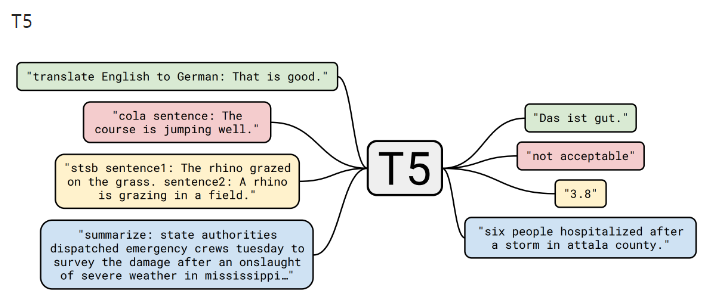

T5는 NLP에서 포괄적인 전이 학습 연구를 수행해 모든 작업을 text-to-text 작업으로 구성하여   
범용의 트랜스포머 아키텍처를 만듬  
T5는 요약을 포함해 여러 작업에서 비지도 학습과 지도 학습 데이터로 훈련함  
따라서 미세 튜닝 없이 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 바로 요약 가능  
그림에서 보듯이 입력 앞에 무슨 작업을 할지 토큰이 들어감

In [18]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
'''
근데 여기서는 앞에 summarize가 필요없음
애초에 pipeline을 불러올때 summarization을 인자로 사용하므로 요약을 목적으로 모델을 불러옴
'''

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

'\n근데 여기서는 앞에 summarize가 필요없음 \n애초에 pipeline을 불러올때 summarization을 인자로 사용하므로 요약을 목적으로 모델을 불러옴\n'

BART는 BERT+GPT-2의 사전 훈련 방식을 사용  
학습된 모델은 미세 튜닝이 필요함  
여기서는 미리 미세 튜닝이 진행된 모델을 불러와서 사용함

In [19]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

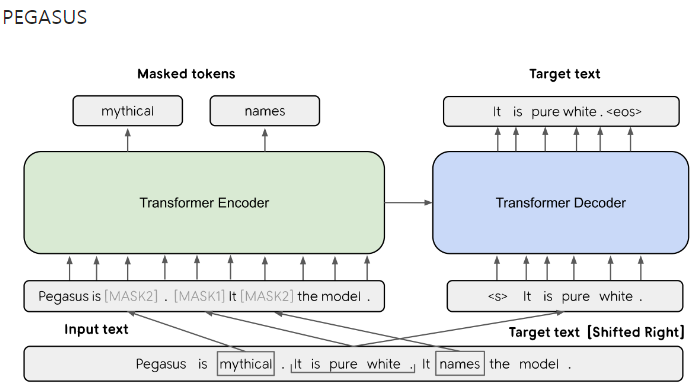

In [20]:
#https://velog.io/@jaehyeong/Paper-Review-PEGASUSPre-training-with-Extracted-Gap-sentences-for-Abstractive-Summarization 여기보고 개념을 이해
#모델 자체에 문장 구별 함수가 있어서 sent_tokenize 함수를 사용하지 않음
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [16]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay.
The fastest man in the world charged clear of United States rival Justin Gatlin
as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and
Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after
Britain were disqualified for a faulty handover.

GPT2
Bolt finished in the top 5 with a time of 4:03.48 in 2:47.01, beating Gatlin who
was 5th with a time of 4:06.82.
He won his first world titles in 2012 but has not been as dominant over the
years.
Despite only having made two appearances at the world championships in the last
few years, with both coming in the same


#생성된 텍스트 품질 평가  

위 결과에서 보이듯이 모델마다 결과가 너무 다름 그럼 최고의 모델의 기준을 어떻게 잡아야 할까??  
I love dog를 번역해도 언어에 따라 여러 방법으로 번역이 가능함  
따라서 단순히참조 번역과 정확히 일치하는지 확인하는 것이 최선의 선택은 아님  
평가 지표를 정의하는 방법을 공부  

# BLEU
요약하면 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신  
단어 또는 n-gram을 체크함 따라서 BLEU는 정밀도를 근간으로 하는 지표   
***
두 텍스트를 비교할 때 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트  
하지만 "The cat is on the mat" , "The the the the the the" 같은 경우  
BLEU는 6/6점이 나옴 왜? The가 6번 등장했으니까   
그래서 하나의 트릭을 줌 최대 수를 참조 텍스트에 등장한 횟수로 클리핑 해버림  
따라서 위의 경우 2/6가 됨  
***
위의 경우를 이용해 n-gram에 똑같이 적용해서 식을 세우면
n-gram에서 생성된 문장을 snt 참조 문장을 snt` 라고 정의
$p_n=\frac{Σ_{n\in snt`}Count_{clip}(n-gram)}{Σ_{n\in snt}Count(n-gram)}$  
일반적으로 데이터가 여러개니까 모든 데이터(C)에 대해 작동하도록 식을 조금 바꿈  
$p_n=\frac{Σ_{snt`\in C}Σ_{n\in snt`}Count_{clip}(n-gram)}{Σ_{snt\in C}Σ_{n\in snt}Count(n-gram)}$  
재현율을 고려하지 않았으므로 짧지만 정밀하게 생성된 시퀀스에 유리함  
이를 보상하기 위해 브레비티 페널티를 추가함  
>재현율이란 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율입니다.  
>좋은 모델은 Precision(정밀도)과 함께 Recall(재현율)을 함께 고려해야 함
***
브레비티 페널티 수식  
$BR=min(1,e^{1-l_{ref}/l_{gen}})$  
생성된 문장의 길이가 참조 문장의 길이보다 작을 때 지수 항이 기하급수적으로 작아짐  
생성된 문장이 cat is 라고하면 정밀도는 최고 나옴 하지만 이상한 번역임  
그래서 패널티 주어짐   
***
최종 수식  
$BLEU-N=BR\times (\Pi^{N}_{n=1}p_n)^{1/N}$  
실제로 N=4일 때 지푤르 많이 사용함  
물론 여기에는 큰 단점들이 존재함 동의어를 고려하지 않음, 토큰화된 텍스트를 기대함  
다양한 BLEU연구가 진행 중임 최근에는 SacreBleu를 사용해 토큰화를 통일시켜버림

In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [9]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

In [10]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

'''
list 에 4개의 값은 n-gram에서 n이 1~4까지 진행한 값
'''

'\nlist 에 4개의 값은 n-gram에서 n이 1~4까지 진행한 값\n'

In [11]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


#ROGUE  
ROUGE는 높은 재현율이 정밀도보다 훨씬 더 중요한 요약같은 작업을 위해 개발됨  
생성된 텍스트와 참조 텍스트에서 여러가지 N-그램이 얼마나 자주 등장하는지 비교한다는 점에서 BLEU와 비슷함  
하지만 ROUGE는 참조 텍스트에 있는 N-그램이 생성된 텍스트에 얼마나 많이 등장하는지도 확인  
> BLEU: 생성된 텍스트에 있는 N-그램이 참조 텍스트에 얼마나 등장하는지 카운트  
> ROUGE: 참조된 텍스트에 있는 N-그램이 생성된 텍스트에 얼마나 등장하는지 카운트  

$ROUGE-N=\frac{Σ_{snt`\in C}Σ_{n\in snt`}Count_{match}(n-gram)}{Σ_{snt`\in C}Σ_{n\in snt`}Count(n-gram)}$  

참조:the cat was under the bed  
생성:the cat was found under the bed  
위의 경우 참조 단어 6개가 모두 생성에 등장했으니 1로 최고 점수 받음 이걸 재현율  
정밀도는 6/7이 되버림 생성에 FOUND가 있으니까
***
ROUGE에는 가장 긴 공통 부분 시퀀스를 측정하는 별도의 점수 ROUGE-L이 있음  
EX: abab와 abc의 LCS는 ab이고 길이는 2 이다.  
두 샘플 사이에서 이 값을 비교하려면 긴 텍스트가 무조건 유리하므로  
정규화가 필요함  
$R_{LCS}=\frac{LCS(X,Y)}{m}$(m=참조 텍스트 길이)   
$P_{LCS}=\frac{LCS(X,Y)}{n}$(n=생성 텍스트 길이)  
$F_{LCS}=\frac{(1+β^2)R_{LCS}P_{LCS}}{R_{LCS}+β^2P_{LCS}}$($β=\frac{P_{LCS}}{R_{LCS}}$)  

In [12]:
rouge_metric = evaluate.load("rouge")

In [21]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.145833,0.021277,0.145833,0.145833
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333
